<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/2D_CNN_colab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [1]:
!nvidia-smi

Thu Jul 15 14:59:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null

In [43]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [44]:
train_normal = []
test_normal = []
train_smurf = []
test_smurf = []
train_ip = []
test_ip = []
train_port = []
test_port = []
train_nmap = []
test_nmap = []

for i in glob.glob('/content/split_images/64x64_V2/80-20/train_normal/train_normal_equ_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/split_images/64x64_V2/80-20/test_normal/test_normal_equ_*.jpg', recursive=True):
    test_normal.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/split_images/64x64_V2/80-20/train_smurf/train_smurf_equ_*.jpg', recursive=True):
    train_smurf.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/split_images/64x64_V2/80-20/test_smurf/test_smurf_equ_*.jpg', recursive=True):
    test_smurf.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

for m in glob.glob('/content/split_images/64x64_V2/80-20/train_ip/train_ip_equ_*.jpg', recursive=True):
    train_ip.append(cv2.imread(m, cv2.IMREAD_GRAYSCALE))

for n in glob.glob('/content/split_images/64x64_V2/80-20/test_ip/test_ip_equ_*.jpg', recursive=True):
    test_ip.append(cv2.imread(n, cv2.IMREAD_GRAYSCALE))
    
for o in glob.glob('/content/split_images/64x64_V2/80-20/train_port/train_port_equ_*.jpg', recursive=True):
    train_port.append(cv2.imread(o, cv2.IMREAD_GRAYSCALE))

for p in glob.glob('/content/split_images/64x64_V2/80-20/test_port/test_port_equ_*.jpg', recursive=True):
    test_port.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE))
    
for q in glob.glob('/content/split_images/64x64_V2/80-20/train_nmap/train_nmap_equ_*.jpg', recursive=True):
    train_nmap.append(cv2.imread(q, cv2.IMREAD_GRAYSCALE))

for r in glob.glob('/content/split_images/64x64_V2/80-20/test_nmap/test_nmap_equ_*.jpg', recursive=True):
    test_nmap.append(cv2.imread(r, cv2.IMREAD_GRAYSCALE))
    


train_normal = np.array(train_normal)
test_normal = np.array(test_normal)
train_smurf = np.array(train_smurf)
test_smurf = np.array(test_smurf)
train_ip = np.array(train_ip)
test_ip = np.array(test_ip)
train_port = np.array(train_port)
test_port = np.array(test_port)
train_nmap = np.array(train_nmap)
test_nmap = np.array(test_nmap)

In [45]:
print(f'Normal train\t{np.shape(train_normal)}\nNormal test\t{np.shape(test_normal)}\nSmurf train\t{np.shape(train_smurf)}\nSmurf test\t{np.shape(test_smurf)}\nIP train\t{np.shape(train_ip)}\nIP test\t\t{np.shape(test_ip)}')
print(f'Port train\t{np.shape(train_port)}\nPort test\t{np.shape(test_port)}\nNmap train\t{np.shape(train_nmap)}\nNmap test\t{np.shape(test_nmap)}')

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

Normal train	(1714, 64, 64)
Normal test	(429, 64, 64)
Smurf train	(122, 64, 64)
Smurf test	(31, 64, 64)
IP train	(5437, 64, 64)
IP test		(1360, 64, 64)
Port train	(1779, 64, 64)
Port test	(445, 64, 64)
Nmap train	(64, 64, 64)
Nmap test	(16, 64, 64)


In [7]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_normal = np.fliplr(train_normal)
vert_flip_train_smurf = np.fliplr(train_smurf)
vert_flip_train_ip = np.fliplr(train_ip)
vert_flip_train_port = np.fliplr(train_port)
vert_flip_train_nmap = np.fliplr(train_nmap)

## flip training images horizonatally
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)
hor_flip_train_smurf = np.rot90(train_smurf, axes = (1,2), k = 2)
hor_flip_train_ip = np.rot90(train_ip, axes = (1,2), k = 2)
hor_flip_train_port = np.rot90(train_port, axes = (1,2), k = 2)
hor_flip_train_nmap = np.rot90(train_nmap, axes = (1,2), k = 2)

## rotate training images left and right once each
# rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
# rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
# rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_normal = np.fliplr(test_normal)
vert_flip_test_smurf = np.fliplr(test_smurf)
vert_flip_test_ip = np.fliplr(test_ip)
vert_flip_test_port = np.fliplr(test_port)
vert_flip_test_nmap = np.fliplr(test_nmap)

## flip testing images horizonatally
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)
hor_flip_test_smurf = np.rot90(test_smurf, axes = (1,2), k = 2)
hor_flip_test_ip = np.rot90(test_ip, axes = (1,2), k = 2)
hor_flip_test_port = np.rot90(test_port, axes = (1,2), k = 2)
hor_flip_test_nmap = np.rot90(test_nmap, axes = (1,2), k = 2)

## rotate testing images left and right once each
# rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
# rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
# rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
# train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack, rotate90l_train_attack, rotate90r_train_attack,
#                    train_normal, vert_flip_train_normal, hor_flip_train_normal, rotate90l_train_normal, rotate90r_train_normal))
# test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack, rotate90l_test_attack, rotate90r_test_attack,
#                   test_normal, vert_flip_test_normal, hor_flip_test_normal, rotate90l_test_normal, rotate90r_test_normal))

train = np.vstack((train_normal, vert_flip_train_normal, hor_flip_train_normal, train_smurf, vert_flip_train_smurf, hor_flip_train_smurf, train_ip, vert_flip_train_ip, hor_flip_train_ip, train_port, vert_flip_train_port, hor_flip_train_port, train_nmap, vert_flip_train_nmap, hor_flip_train_nmap))
test = np.vstack((test_normal, vert_flip_test_normal, hor_flip_test_normal, test_smurf, vert_flip_test_smurf, hor_flip_test_smurf, test_ip, vert_flip_test_ip, hor_flip_test_ip, test_port, vert_flip_test_port, hor_flip_test_port, test_nmap, vert_flip_test_nmap, hor_flip_test_nmap))

In [46]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_smurf, train_ip, train_port, train_nmap))
test = np.vstack((test_normal, test_smurf, test_ip, test_port, test_nmap))

train.shape, test.shape

((9116, 64, 64), (2281, 64, 64))

In [47]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

train.shape, test.shape

((9116, 64, 64, 1), (2281, 64, 64, 1))

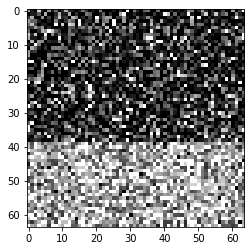

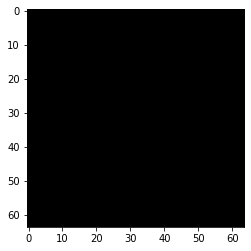

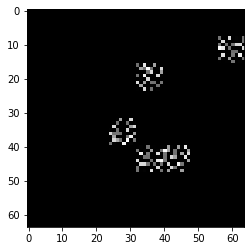

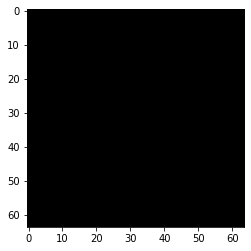

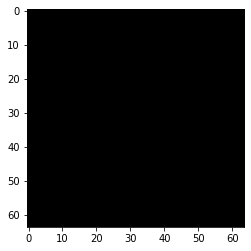

In [ ]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [48]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []

for i in range(0, train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [49]:
pd.DataFrame(training_labels)

,0
0,Normal
1,Normal
2,Normal
3,Normal
4,Normal
...,...
9111,Nmap-Sweep
9112,Nmap-Sweep
9113,Nmap-Sweep
9114,Nmap-Sweep


In [9]:
## create the training and testing data labels
## run this cell if using augmented data with rotated data

training_labels = []

for i in range(0, train_normal.shape[0] + vert_flip_train_normal.shape[0] + hor_flip_train_normal.shape[0]):
    training_labels.append('Normal')

for j in range(0, train_smurf.shape[0] + vert_flip_train_smurf.shape[0] + hor_flip_train_smurf.shape[0]):
    training_labels.append('Smurf-DDoS')
    
for k in range(0, train_ip.shape[0] + vert_flip_train_ip.shape[0] + hor_flip_train_ip.shape[0]):
    training_labels.append('IP-Sweep')
    
for l in range(0, train_port.shape[0] + vert_flip_train_port.shape[0] + hor_flip_train_port.shape[0]):
    training_labels.append('Port-Sweep')
    
for m in range(0, train_nmap.shape[0] + vert_flip_train_nmap.shape[0] + hor_flip_train_nmap.shape[0]):
    training_labels.append('Nmap-Sweep')



testing_labels = []

for i in range(0, test_normal.shape[0] + vert_flip_test_normal.shape[0] + hor_flip_test_normal.shape[0]):
    testing_labels.append('Normal')

for j in range(0, test_smurf.shape[0] + vert_flip_test_smurf.shape[0] + hor_flip_test_smurf.shape[0]):
    testing_labels.append('Smurf-DDoS')
    
for k in range(0, test_ip.shape[0] + vert_flip_test_ip.shape[0] + hor_flip_test_ip.shape[0]):
    testing_labels.append('IP-Sweep')
    
for l in range(0, test_port.shape[0] + vert_flip_test_port.shape[0] + hor_flip_test_port.shape[0]):
    testing_labels.append('Port-Sweep')
    
for m in range(0, test_nmap.shape[0] + vert_flip_test_nmap.shape[0] + hor_flip_test_nmap.shape[0]):
    testing_labels.append('Nmap-Sweep')

In [ ]:
## create the training and testing data labels
## run this cell if using augmented data and not with rotated data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [11]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(      IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0            0           0       1           0           0
 1            0           0       1           0           0
 2            0           0       1           0           0
 3            0           0       1           0           0
 4            0           0       1           0           0
 ...        ...         ...     ...         ...         ...
 9111         0           1       0           0           0
 9112         0           1       0           0           0
 9113         0           1       0           0           0
 9114         0           1       0           0           0
 9115         0           1       0           0           0
 
 [9116 rows x 5 columns],
       IP-Sweep  Nmap-Sweep  Normal  Port-Sweep  Smurf-DDoS
 0            0           0       1           0           0
 1            0           0       1           0           0
 2            0           0       1           0           0
 3          

In [50]:
## standard scaler for the output labels
x = train.drop("attack_type", axis = 1)
sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(x))
y = train["attack_type"]

y_cat = to_categorical(y)

AttributeError: ignored

In [12]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 42)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 42)

In [13]:
KERNEL_SIZE = [2,2]
IMAGE_SIZE = [64,64,1]

cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 2
cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 3
cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.25))

## convolution 4
cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 5
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

# ## convolution 6
# cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
# cnn.add(AveragePooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
# cnn.add(Dense(256, activation='relu'))
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(64, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation = 'softmax'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        80        
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
average_pooling2d_2 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         3

In [14]:
start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 256, epochs = 250)
end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
print(f'Training finished in {round(end - start, 2)}')

Epoch 1/250
36/36 [==============================] - 33s 24ms/step - loss: 1.4432 - accuracy: 0.6207
Epoch 2/250
36/36 [==============================] - 1s 17ms/step - loss: 0.9045 - accuracy: 0.6579
Epoch 3/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8917 - accuracy: 0.6654
Epoch 4/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8791 - accuracy: 0.6700
Epoch 5/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8695 - accuracy: 0.6753
Epoch 6/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8554 - accuracy: 0.6857
Epoch 7/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8463 - accuracy: 0.6919
Epoch 8/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8353 - accuracy: 0.6992
Epoch 9/250
36/36 [==============================] - 1s 17ms/step - loss: 0.8303 - accuracy: 0.7007
Epoch 10/250
36/36 [==============================] - 1s 18ms/step - loss: 0.8193 - accuracy: 0.705

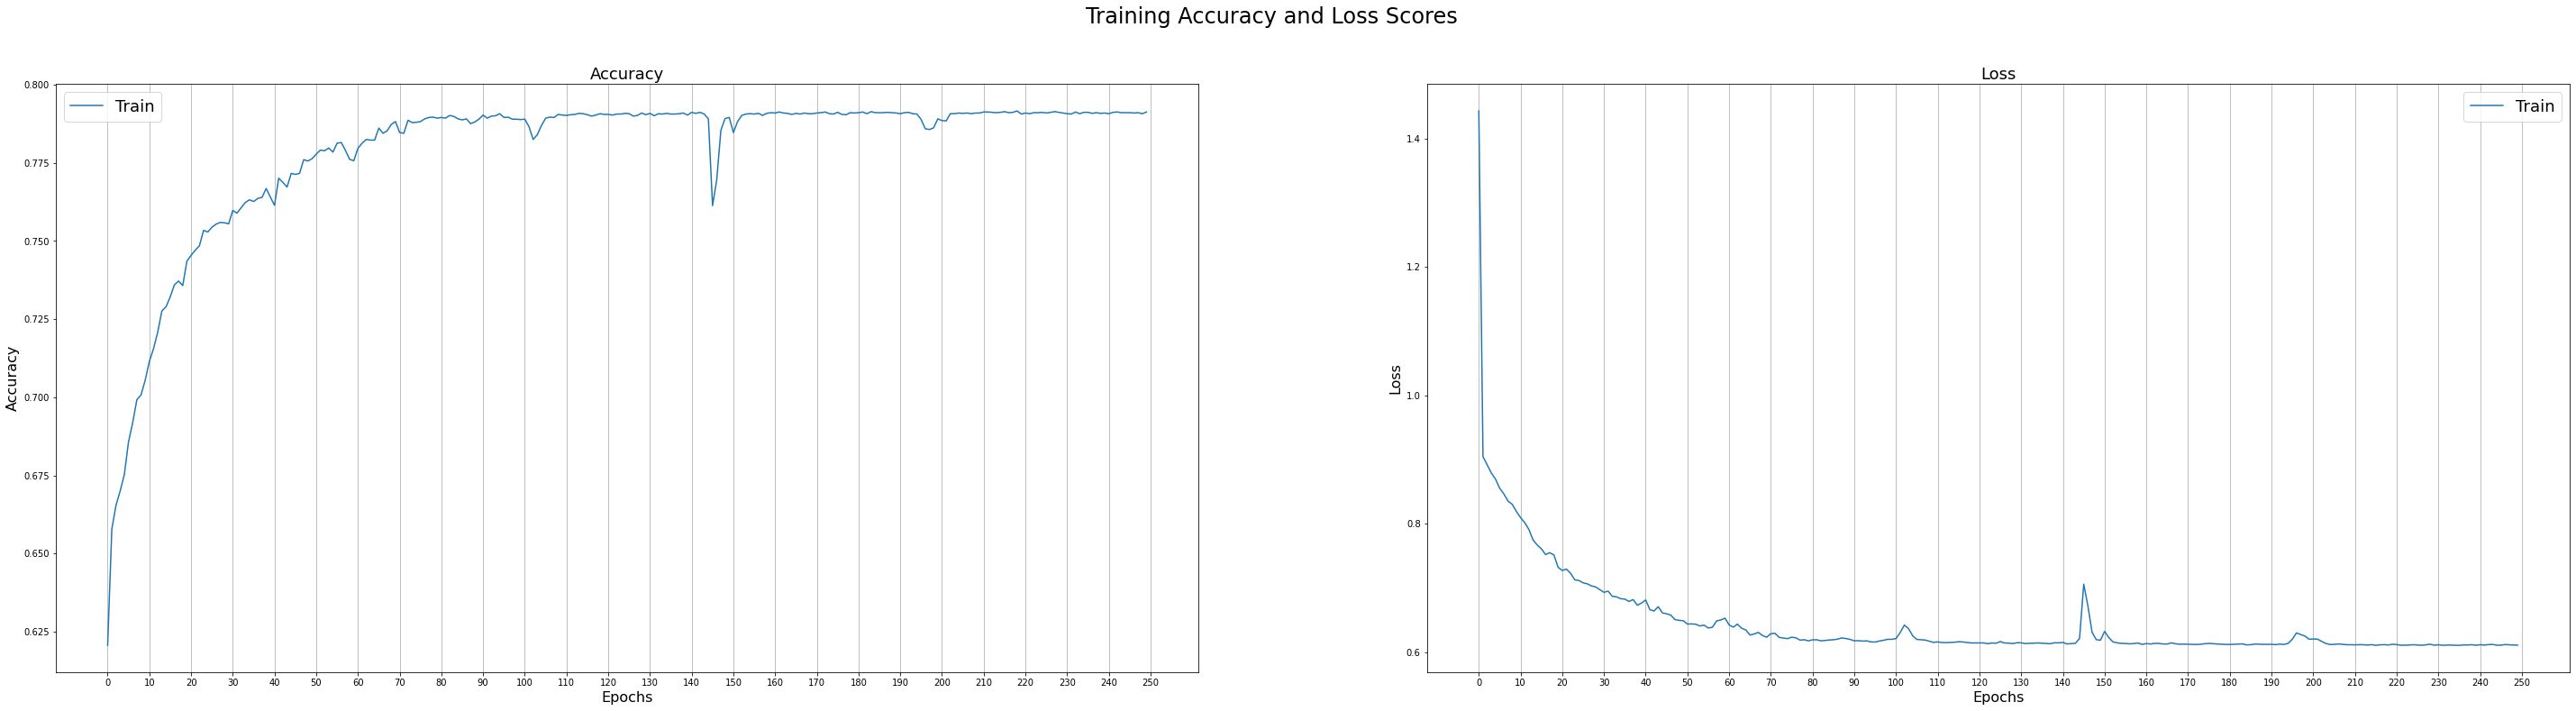

In [16]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 260, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 260, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [17]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 256, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 1.7507	Accuracy = 65.45%


In [18]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

print('\tIP\tNmap\tNormal\tPort\tSmurf\n')
preds[:20]

	IP	Nmap	Normal	Port	Smurf



array([[0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.00236, 0.     , 0.02865, 0.96898, 0.     ],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.00057, 0.00002, 0.94963, 0.04978, 0.     ],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.8406 , 0.     , 0.15938, 0.00002, 0.     ],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.68772, 0.00336, 0.13488, 0.15889, 0.01515],
       [0.78513, 0.     , 0.21486, 0.00001, 0.     ],
       [0.68772, 0.00336, 0.

In [19]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (KERNEL_SIZE), padding="same", activation='relu', input_shape = (IMAGE_SIZE)))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    ## convolution 5
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # # cnn.add(Dropout(0.5))

    # ## convolution 6
    # cnn.add(Convolution2D(128, (KERNEL_SIZE), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    # cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(64, activation='relu'))
    # cnn.add(Dense(32, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(5, activation = 'softmax'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 256, epochs = 300)

In [1]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(classifier, test, ytest, cv = kf)
print(f'Model Cross Validation: \n{round(score.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{score}')

NameError: ignored

In [38]:
y = to_categorical(ytest)

In [ ]:
y

In [42]:
classification_report(y, preds, target_names=ytest.columns)
# multilabel_confusion_matrix(ytest, preds, labels = ['IP-Sweep','Nmap-Sweep','Normal','Port-Sweep','Smurf-DDoS'])

ValueError: ignored